## Дз 7: "Metric learning"

ФИО: Фадеев Роман Андреевич

## Цель задания:
Познакомится с алгоритмами metric learning
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу поиска похожего автомобиля в базе данных (автомобиля того же класса). На основе датасета [cars196](https://paperswithcode.com/sota/metric-learning-on-cars196) , ссылка на данные [мета](https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing) [data](https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing).

Процесс выполнения задания следующий:

0. Выбор модели эмбеддера:
    1. Выберите модель кодирующую изображения для выполнения домашнего задания. Любую, кроме модели resnet50.

1. Подготовка обучающего набора данных
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера).
    2. Добавьте аугментации в датасет **0.5 балла**.

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте train-loop для вашей модели и проведите обучение c Triplet loss **2 балла**.
    2. При формировании триплета не просто брать отрицательный класс, а воспользоваться техникой hard negative mining **0.5 балла**.
    3. Обучите модель и воcпользуйте иными loss функциями для задачи metric learning **0.5 балла**.
    4. Полезные ссылки [тык](https://github.com/KevinMusgrave/pytorch-metric-learning)
 
3. Валидация обученных моделей на тестовой выборке, вычисление метрики Recall и Precision
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрики поиска Recall@1, Recall@5, Precision@1, Precision@5. Обратите внимание, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта, а должны производить поиск на основе получившихся эмбеддингов (пример в [семинаре](metric_learning.ipynb) блок Faiss). **0.5 балла**
    2. При поиске воспользоваться библиотекой Faiss **0.5 балла**

4. Выводы:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.
    3. Проинтерпретируйте результаты работы модели с помощью [GradCam](https://github.com/jacobgil/pytorch-grad-cam)  **0.5 балла**

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import scipy.io
mat = scipy.io.loadmat('./big-data/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./big-data/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [ ]:
ADD_PATH = './big-data/cars_train/cars_train'

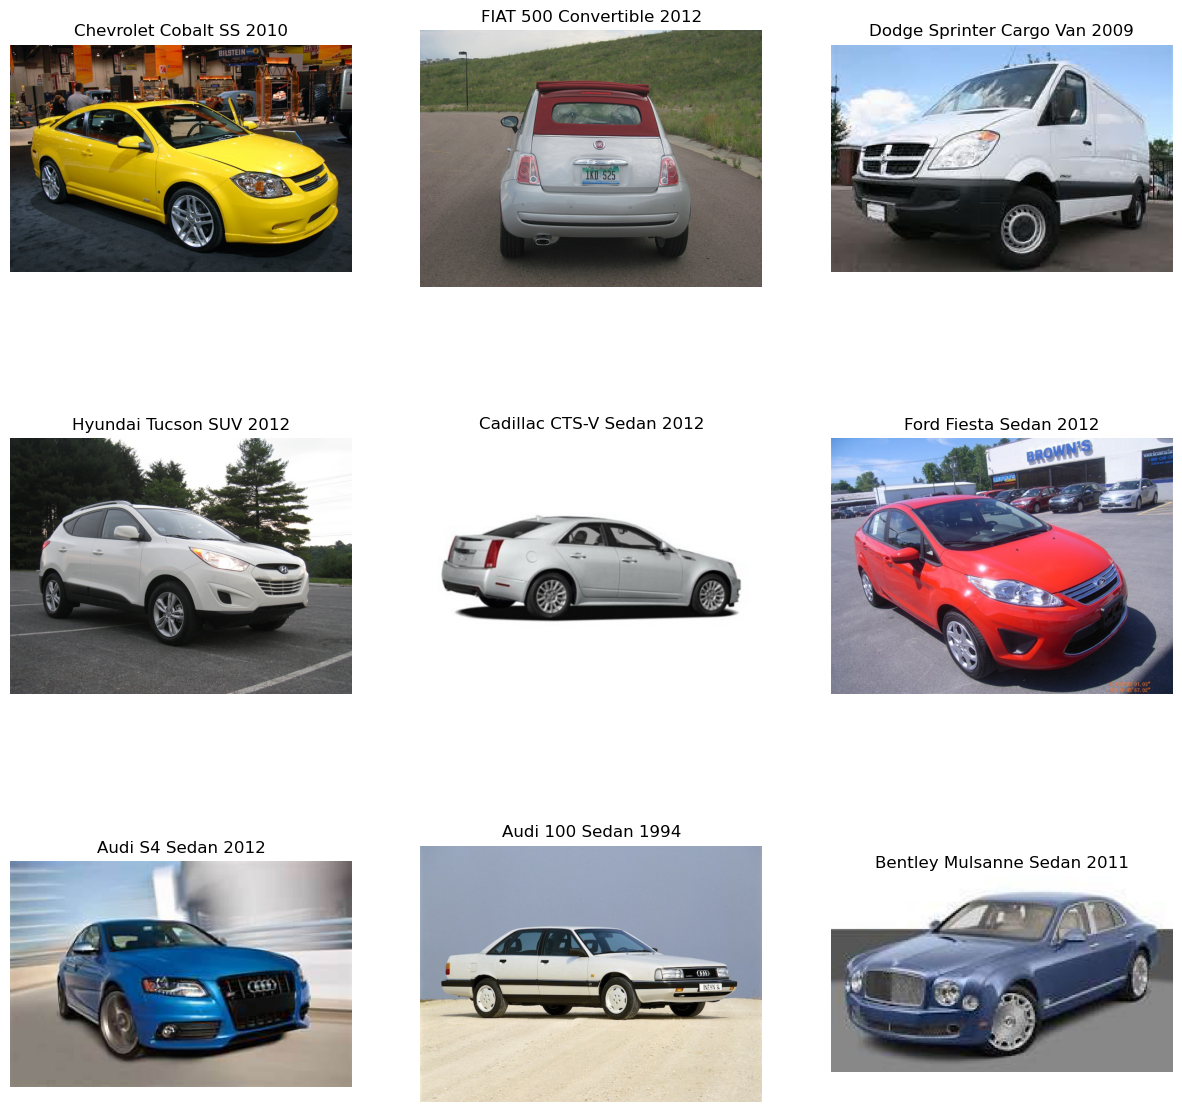

In [4]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

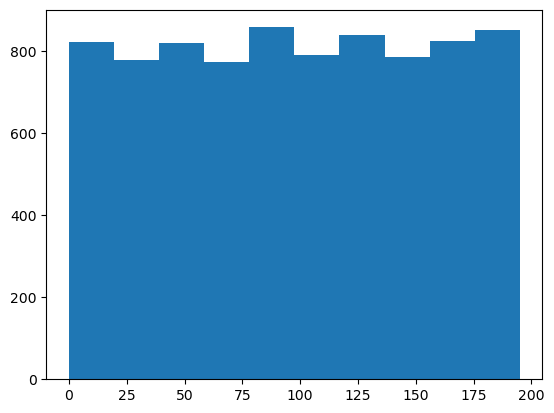

In [5]:
plt.hist(fname_to_class.values())
plt.show()

In [6]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_transfroms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), 
    torchvision.transforms.Resize(
        size=(224, 224)
    ),
    
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(degrees=(-15, 15)),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    torchvision.transforms.ToTensor(),  
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms =  torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), 
    torchvision.transforms.Resize(
        size=(224, 224)
    ),
    torchvision.transforms.ToTensor(),  
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms
        
    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [7]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, val_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=None, pin_memory=True)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from torchvision.models import mobilenet_v2

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

class CarClassifier(pl.LightningModule):
    def __init__(self, class_dict, learning_rate=1e-3, emb_size=512, margin=1.0, alpha = 0.5):
        super().__init__()
        self.class_dict = class_dict
        self.learning_rate = learning_rate
        self.alpha = alpha
        
        self.model = mobilenet_v2(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=emb_size),
            nn.ReLU(inplace=False)
        )
        
        self.classification_loss = nn.CrossEntropyLoss()
        self.triplet_loss = TripletLoss(margin=margin)
        self.save_hyperparameters()

    def forward(self, images):
        return self.model(images)
    
    def generate_triplets(self, batch):
        anchors, positives, negatives = [], [], []
        embeddings = self.model(batch['image'])
        labels = batch['label']

        for i in range(len(labels)):
            anchor = embeddings[i]
            anchor_label = labels[i]

            positive_candidates = [j for j in range(len(labels)) if labels[j] == anchor_label and j != i]
            if not positive_candidates:
                continue
            positive_idx = random.choice(positive_candidates)
            positive = embeddings[positive_idx]

            negative_candidates = [j for j in range(len(labels)) if labels[j] != anchor_label]
            if not negative_candidates:
                continue

            neg_distances = [
                F.pairwise_distance(anchor.unsqueeze(0), embeddings[j].unsqueeze(0)).item()
                for j in negative_candidates
            ]
            hardest_negative_idx = negative_candidates[neg_distances.index(min(neg_distances))]
            negative = embeddings[hardest_negative_idx]

            anchors.append(anchor)
            positives.append(positive)
            negatives.append(negative)

        if not anchors:
            raise ValueError("Cannot generate triplets: not enough data in the batch.")

        return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)

    def training_step(self, batch, batch_idx):
        anchors, positives, negatives = self.generate_triplets(batch)
        loss = self.triplet_loss(anchors, positives, negatives)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        anchors, positives, negatives = self.generate_triplets(batch)
        loss = self.triplet_loss(anchors, positives, negatives)
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)
        classification_loss = self.classification_loss(preds, labels)
        final_loss = loss * self.alpha + classification_loss
        self.log("val_loss", final_loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [10]:
pl_model = CarClassifier(id_to_car, 3e-4, emb_size=1000)
checkpoint_callback = ModelCheckpoint(monitor='val_loss',mode='min',  save_top_k=3)

early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = pl.Trainer(max_epochs = 20, accelerator=device, devices = 1, callbacks=[checkpoint_callback, lr_monitor, early_stopping])

C:\dev\miniconda\envs\ds\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\dev\miniconda\envs\ds\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
MODEL_READY = True

if MODEL_READY:
    pl_model.load_state_dict(torch.load("weights-mobilenet.pth", map_location=device))
else:
    trainer.fit(model=pl_model, train_dataloaders=train_loader, 
            val_dataloaders=valid_loader)
    
    torch.save(pl_model.state_dict(), "weights-mobilenet.pth")

In [12]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\dev\miniconda\envs\ds\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Validation: |                                                                     | 0/? [00:00<?, ?it/s]

─────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             7.957975387573242
─────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 7.957975387573242}]

Получение эмбеддингов

In [14]:
import tqdm
import numpy as np
pl_model.eval()
pl_model.to(device)
np.float32

numpy.float32

In [15]:
def get_embeds(model, loader):
    embeddings = np.empty((1,1000))
    labels = np.empty((1))
    for batch in tqdm.tqdm(loader):
        imgs = batch['image']
        label = batch['label']
        with torch.no_grad():
            preds = model(imgs.to(device))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:]

In [16]:
train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

100%|███████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.18s/it]


Вычисляем также Center Loss и Contrastive Loss

In [31]:
import torch

def compute_center_loss(embeddings, labels):
    embeddings = torch.tensor(embeddings) if not isinstance(embeddings, torch.Tensor) else embeddings
    labels = torch.tensor(labels) if not isinstance(labels, torch.Tensor) else labels

    unique_labels = torch.unique(labels)
    centers = {
        label.item(): embeddings[labels == label].mean(dim=0)
        for label in unique_labels
    }

    center_loss = 0.0
    for label in unique_labels:
        class_embeddings = embeddings[labels == label]
        center = centers[label.item()]
        dist = torch.norm(class_embeddings - center, p=2)
        center_loss += ((dist ** 2) / 2).sum().item()

    center_loss /= len(embeddings)
    return center_loss

def compute_contrastive_loss(embeddings, labels, margin=1.0):
    embeddings = torch.tensor(embeddings) if not isinstance(embeddings, torch.Tensor) else embeddings
    labels = torch.tensor(labels) if not isinstance(labels, torch.Tensor) else labels

    contrastive_loss = 0.0
    num_pairs = 0

    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            dist = torch.norm(embeddings[i] - embeddings[j], p=2)
            if labels[i] == labels[j]:
                contrastive_loss += dist ** 2
            else:
                contrastive_loss += max(0, margin - dist.item()) ** 2

            num_pairs += 1

    contrastive_loss /= num_pairs
    return contrastive_loss

In [32]:
center_loss = compute_center_loss(val_emb, val_labels)
print(f"Center Loss: {center_loss}")

contrastive_loss = compute_contrastive_loss(val_emb, val_labels, margin=1.0)
print(f"Contrastive Loss: {contrastive_loss}")

Center Loss: 20.024263479725725
Contrastive Loss: 0.4691340923309326


Визуализация эмбеддингов

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', s=5)
    plt.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="upper right")
    plt.title("t-SNE visualization of embeddings")
    plt.show()

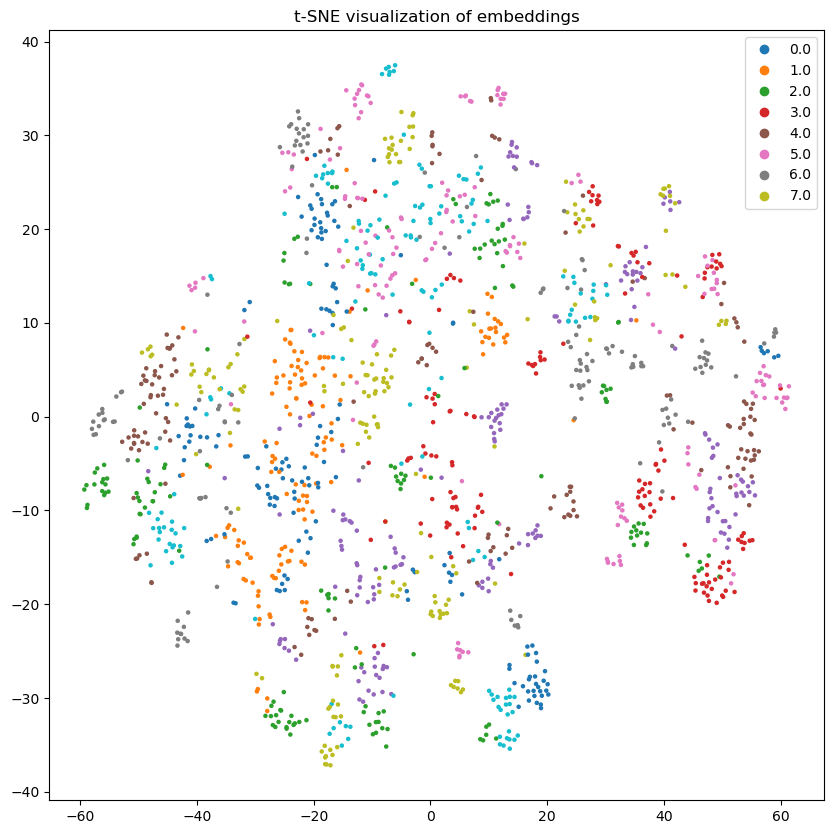

In [34]:
visualize_embeddings(val_emb, val_labels)

Вычисление метрик на основе расстояния векторов

In [35]:
import faiss                   # make faiss available
index = faiss.IndexFlatL2(1000)   # build the index
print(index.is_trained)
index.add(train_emb)                  # add vectors to the index
print(index.ntotal)

k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(train_emb[:5], k) # sanity check
print(I)
print(D)
D, I = index.search(val_emb, k)     # actual search
print(I[:5])                   # neighbors of the 5 first queries
print(I[-5:]) 

True
6400
[[   0  354 4265 5866]
 [   1 2824 3684 3281]
 [   2 5475 6047 4254]
 [   3 5065 5377 3754]
 [   4  203 1315 1594]]
[[ 0.       67.01926  69.4111   71.89982 ]
 [ 0.       34.257214 35.506348 36.174892]
 [ 0.       41.616566 45.24985  46.732002]
 [ 0.       51.2891   51.37954  55.239975]
 [ 0.       42.916718 43.15422  46.093163]]
[[5295 3167 1415 3072]
 [2962 4707 4248 1841]
 [3259 4692 2661 1594]
 [2295 1299 2415  699]
 [3144 1522 6005 5485]]
[[5645 3702 1533 2831]
 [3606 5709 1101 5472]
 [6093 1939 5993 4668]
 [5201  596 2892 2648]
 [1188  648 4488 5383]]


In [36]:
Distances, Indexes = index.search(val_emb, 1)

In [37]:
print(f'Precision/Recall @ 1 : {np.sum((val_labels == train_labels[Indexes.flatten()]))/val_labels.shape[0]}')

Precision/Recall @ 1 : 0.6942909760589319


In [38]:
import numpy as np

def precision_at_k(y_true, y_pred, k):
    true_positive = 0
    k = min(k, len(y_true))
    
    for i in range(len(y_true)):
        true_positive += (np.sum(y_true[i] == y_pred[i]) / k)
    
    precision = true_positive / len(y_true)
    return precision

def recall_at_k(y_true, y_pred, y_all, k):
    true_positive = 0
    false_negative = 0
    k = min(k, len(y_true))
    
    for i in range(len(y_true)):
        cur_tp = np.sum(y_true[i] == y_pred[i])
        true_positive += cur_tp
        false_negative += np.count_nonzero(y_all == y_true[i])
    
    recall = true_positive / (true_positive + false_negative)
    return recall

def mean_average_precision(y_true, y_pred, k):
    mAP = 0
    k = min(k, len(y_true))
    
    for i in range(len(y_true)):
        num_correct = 0
        average_precision = 0
        for j in range(k):
            pred = y_true[i] == y_pred[i][j]
            num_correct += pred
            average_precision += num_correct / (j + 1)
        
        mAP += average_precision / k
    
    mAP = mAP / len(y_true)
    return mAP

def show_metrics(y_true, index, k=1):
    Distances, Indexes = index.search(val_emb, k)

    y_true = y_true.astype(int)
    y_pred = train_labels[Indexes].astype(int)
    
    precision = precision_at_k(y_true, y_pred, k)
    recall = recall_at_k(y_true, y_pred, val_labels, k)
    mAP = mean_average_precision(y_true, y_pred, k)

    precision_str = f"{precision:.5f}"
    recall_str = f"{recall:.5f}"
    mAP_str = f"{mAP:.5f}"

    data = [["Precision", precision_str],
            ["Recall", recall_str],
            ["mAP", mAP_str]]

    print(f"Metric @{k}")
    print(data)

In [39]:
show_metrics(y_true=val_labels, index=index, k=1)

Metric @1
[['Precision', '0.69429'], ['Recall', '0.06896'], ['mAP', '0.69429']]


In [40]:
show_metrics(y_true=val_labels, index=index, k=5)

Metric @5
[['Precision', '0.62394'], ['Recall', '0.24972'], ['mAP', '0.65756']]


In [41]:
show_metrics(y_true=val_labels, index=index, k=20)

Metric @20
[['Precision', '0.49592'], ['Recall', '0.51413'], ['mAP', '0.57589']]


Интерпретация модели разными реализациями CAM

In [42]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [43]:
transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(), 
                        torchvision.transforms.Resize(
                            size=(224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])

def show_diff_grad_methods(model, methods):
    model.eval()
    num_imgs = 8
    rows = len(methods)
    fig, ax = plt.subplots(rows, num_imgs, figsize = (30, 30))
    random_images = random.sample([i for i in range(len(fname_to_class))], num_imgs)
    for row_id, method in enumerate(methods):
        for col_id, im_idx in enumerate(random_images):
            filename, cl_id = list(fname_to_class.items())[im_idx]
            temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
            temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
            rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
            transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
            target_layers = [model.features[7]]
            cam = method(model=model, target_layers=target_layers)
            grayscale_cam = cam(input_tensor=transformed_im)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
            ax[row_id][col_id].imshow(visualization)
            ax[row_id][col_id].set_title(f"method : {str(method).split('.')[-1][:-2]} \n gt : {id_to_car[cl_id]}")
            ax[row_id][col_id].axis('off')

100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.48it/s]


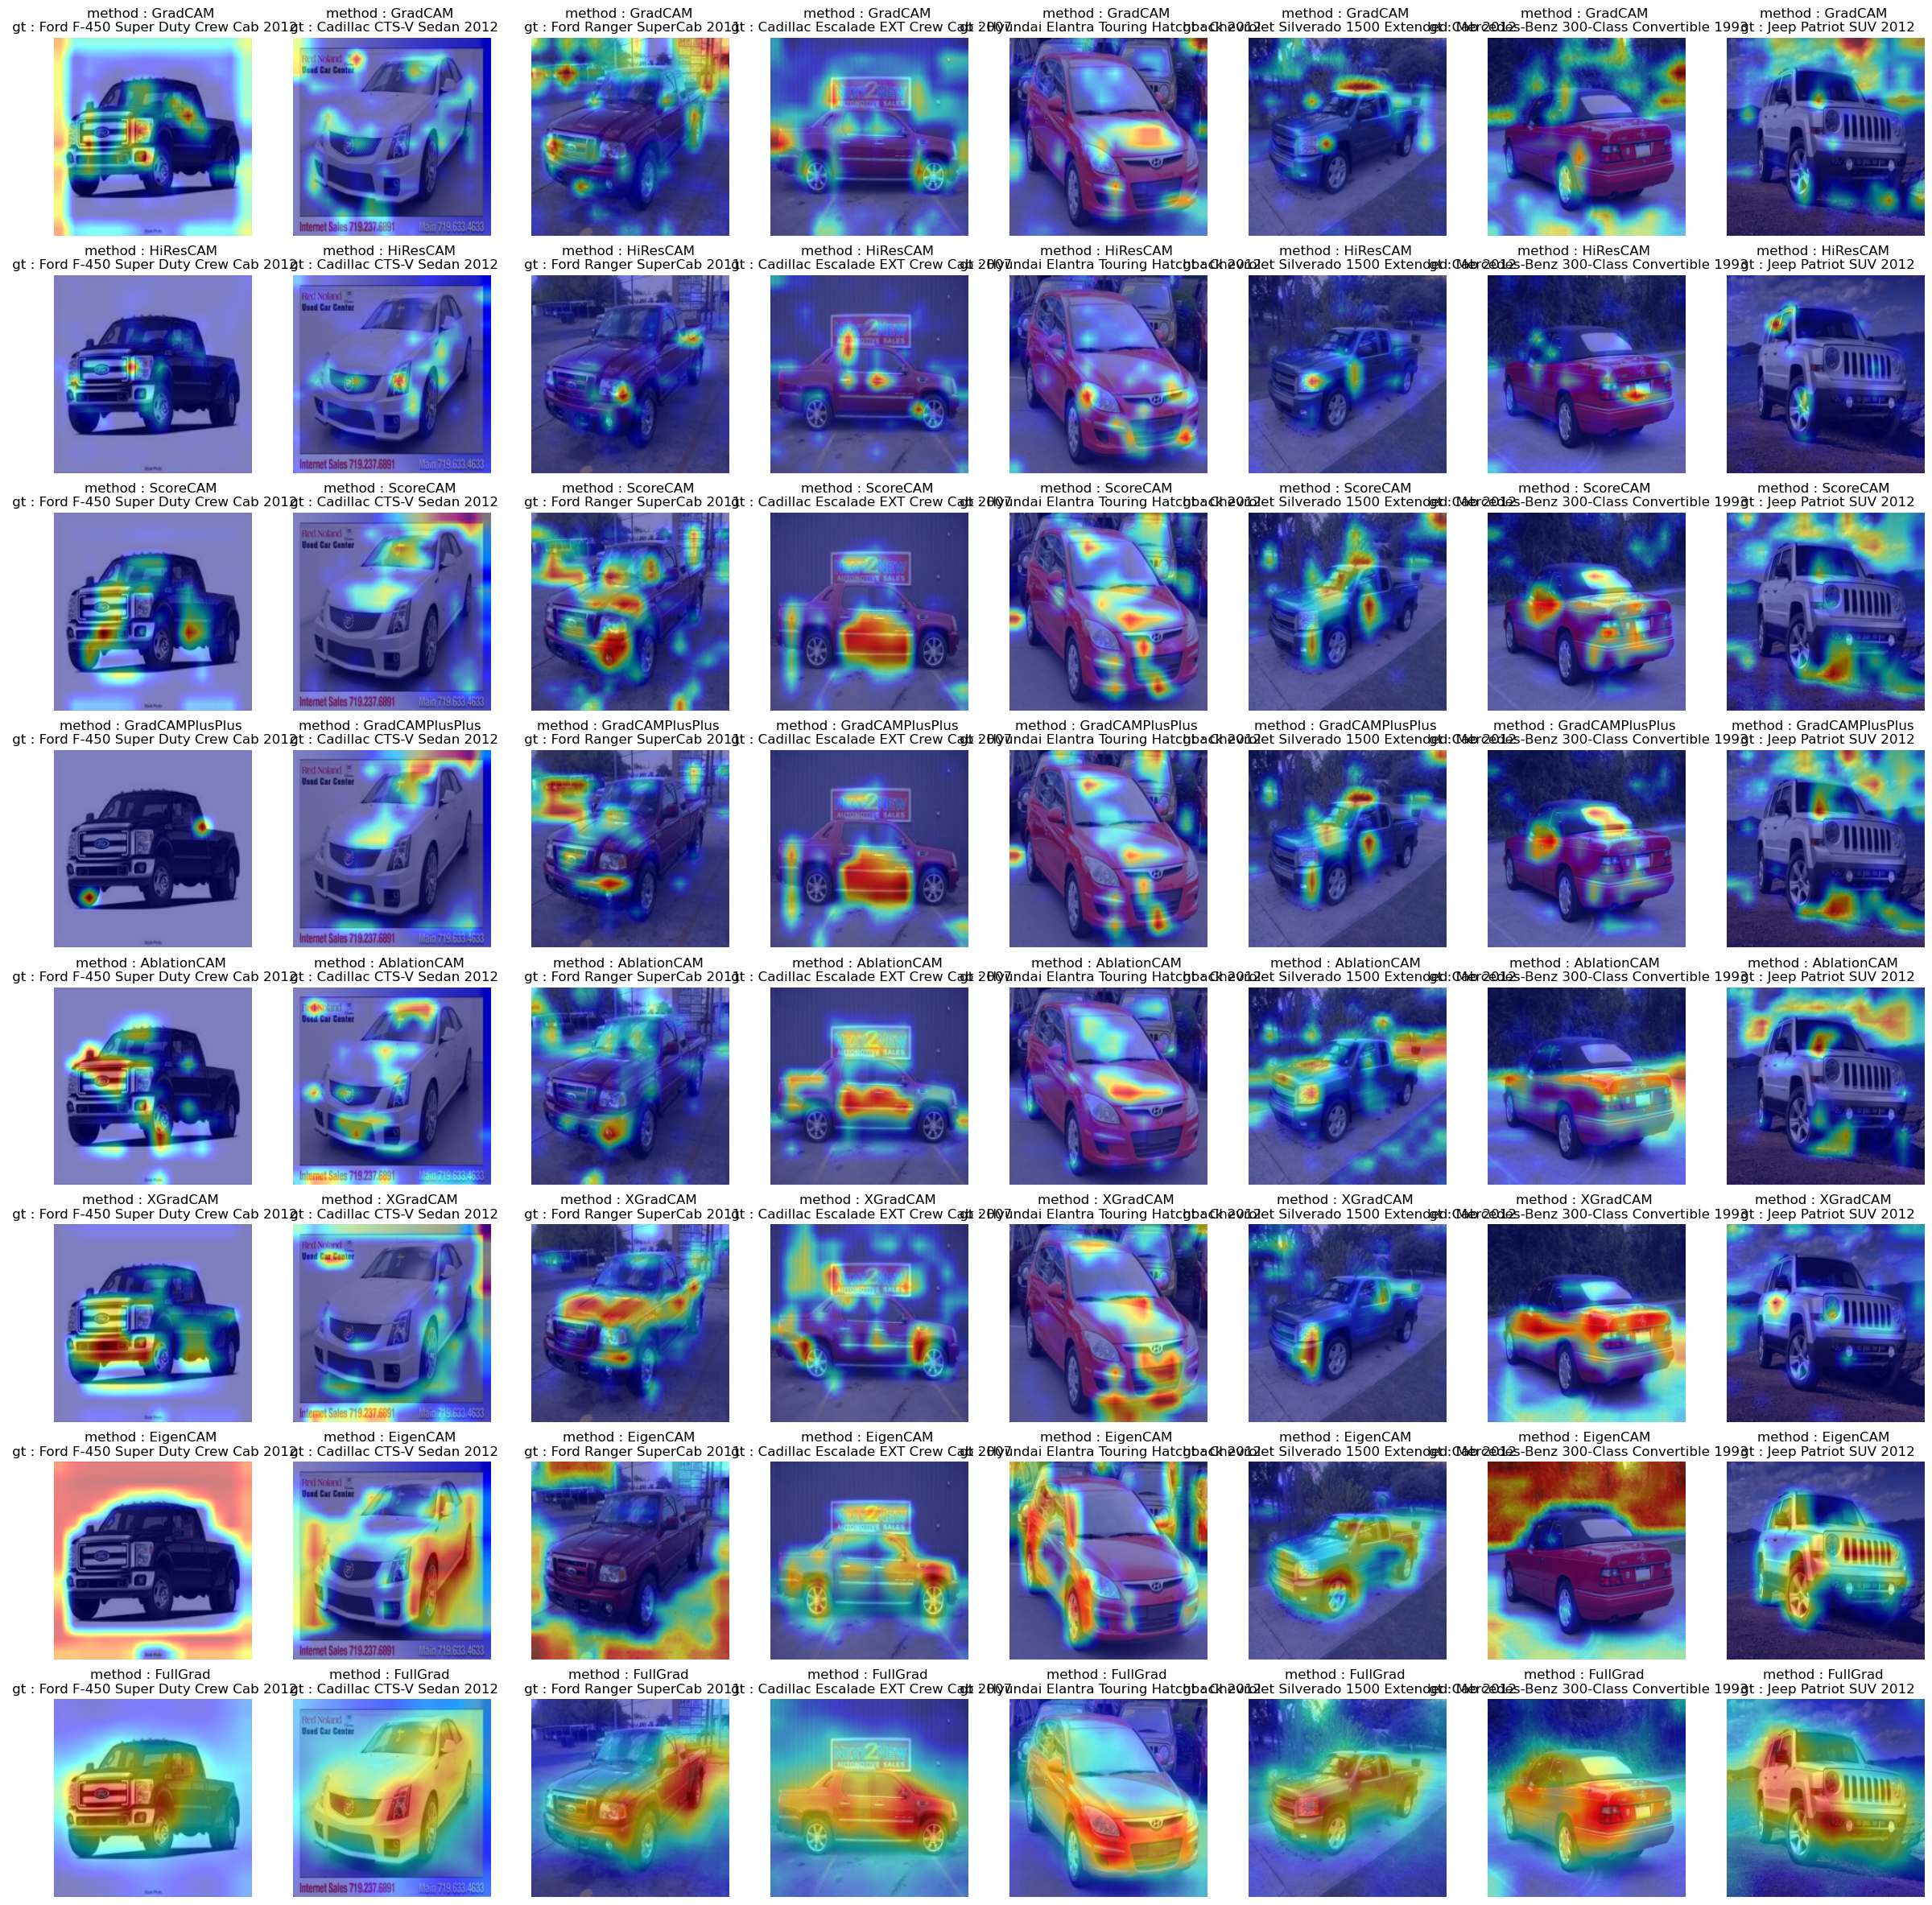

In [44]:
show_diff_grad_methods(pl_model.model, [ GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad])

## Выводы

- На визуализации эмбеддингов видно, что модель что модель хорошо сгруппировала объекты одного класса, причем многие кластеры имеют высокую плотность, что говорит о хорошем результате работы модели;
- Лосс-функции имеют неплохие результаты;
- Главная проблема заключается в частых пересечениях объектов разных кластеров;
- Наверное, хотелось бы, чтобы кластеры были большего размера

- Для более точного отличия эмбеддингов можно увеличить их размеры;
- Использовать более эффективные архитектуры, например, resnet;
- Использовать более сложные стратегия вычисления loss-функции;
- Подобрать получше гиперпараметры